# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1 Подготовка

In [15]:
import numpy as np
import pandas as pd
import os

import re

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve

from sklearn.utils import shuffle

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Загрузим датасет:

In [2]:
pth1 = "D:/YP/ML/comments/toxic_comments.csv"
pth2 = "/datasets/toxic_comments.csv"

if os.path.exists(pth1):
    df_comments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_comments = pd.read_csv(pth2)
else:
    print('Something is wrong')

Посмотрим первые строки:

In [3]:
display(df_comments.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим информацию о фрейме:

In [4]:
display(df_comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [5]:
print('Дубликатов в датасете:', df_comments.duplicated().sum())

Дубликатов в датасете: 0


In [6]:
print('Пропусков: \n', df_comments.isna().sum())

Пропусков: 
 Unnamed: 0    0
text          0
toxic         0
dtype: int64


Посмотрим соотношение токсичных и нектоксичных комментариев:

In [7]:
display(df_comments['toxic'].value_counts(), df_comments.toxic.value_counts(normalize=True))

0    143106
1     16186
Name: toxic, dtype: int64

0    0.898388
1    0.101612
Name: toxic, dtype: float64

<AxesSubplot:ylabel='Type'>

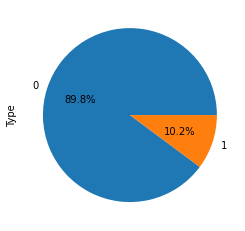

In [8]:
df_comments.groupby('toxic').size().plot(kind='pie',
                                       y = "toxic",
                                       label = "Type",
                                       autopct='%1.1f%%')

### Промежуточный вывод:

1. В таблице 159292 строк без пропусков и явных дубликатов.
2. Классы несбалансированы, небходимо будет использовать методы балансировки.
3. Столбец `Unnamed: 0` дублирует индексы, удалим его.

### Подготовка данных:

Удалим столбец `Unnamed: 0`:

In [9]:
df_comments = df_comments.drop(['Unnamed: 0'], axis=1)

Создадим функицю для очистки текстов комменитариев:

In [10]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [11]:
%%time

df_comments['text'] = df_comments['text'].apply(clear_text) 

CPU times: user 5.13 s, sys: 36.8 ms, total: 5.17 s
Wall time: 5.33 s


In [12]:
df_comments.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Лемматизируем текст:

In [16]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,             
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)


In [18]:
df_comments['text'] = df_comments['text'].apply(lemmatize_text)


In [19]:
df_comments.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Разделим выборки на 50/25/25:

In [20]:
features = df_comments.drop(['toxic'], axis=1) 
target = df_comments['toxic']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.5, random_state=5678)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=5678)

In [21]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(79646, 1)
(39823, 1)
(39823, 1)
(79646,)
(39823,)
(39823,)


In [22]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
features_train = count_tf_idf.fit_transform(features_train['text'].values)
features_valid = count_tf_idf.transform(features_valid['text'].values)
features_test = count_tf_idf.transform(features_test['text'].values)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(79646, 99078)
(39823, 99078)
(39823, 99078)


### Балансировка классов:

Ресемплинг с уменшением класса 0:

In [24]:
toxic_comments_train = df_comments.iloc[target_train.index]

target_train_class_untoxic = toxic_comments_train[toxic_comments_train['toxic'] == 0]
target_train_class_toxic = toxic_comments_train[toxic_comments_train['toxic'] == 1]
print(target_train_class_untoxic.shape)
print(target_train_class_toxic.shape)

(71586, 2)
(8060, 2)


In [25]:
target_train_class_untoxic_downsample = resample(target_train_class_untoxic, replace=True, n_samples=len(target_train_class_toxic), random_state=5678)
print(target_train_class_untoxic_downsample.shape)

(8060, 2)


In [26]:
target_train_downsample = pd.concat([target_train_class_untoxic_downsample, target_train_class_toxic])

0    8060
1    8060
Name: toxic, dtype: int64


<AxesSubplot:ylabel='Type'>

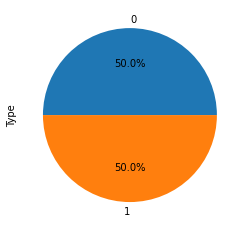

In [27]:
print(target_train_downsample["toxic"].value_counts())

target_train_downsample.groupby('toxic').size().plot(kind='pie',
                                       y = "toxic",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [28]:
features_train_downsample = df_comments.iloc[target_train_downsample.index]

features_train_resample, target_train_resample = shuffle(features_train_downsample, target_train_downsample, random_state=5678)

features_train_downsample = count_tf_idf.transform(features_train_downsample['text'].values)

### Вывод:

1. В ходе подготовки данных мы получили признаки для обучения, получили обучающую, валидационную и тестовую выборку.

2. Сбалансировали целевой признак, но в дальнейшем будем и балансировать по весам признаки в самих моделях обучения.

## 2 Обучение

### Logistic Regression

Вначале займемся Логистической регрессией с downsapling-ом 

In [29]:
target_train_downsample = target_train_downsample['toxic']

In [30]:
LR = LogisticRegression(random_state=5678)
LR.fit(features_train_downsample, target_train_downsample)

LogisticRegression(random_state=5678)

In [31]:
predicted_LR = LR.predict(features_valid)
valid_f1_LR = f1_score(predicted_LR, target_valid)
print('F1 на валидации:', valid_f1_LR)

F1 на валидации: 0.6868962825641526


А теперь Логистическая регрессия с GridSearchCV и балансом классов:

In [32]:
LR_balanced = LogisticRegression(class_weight='balanced', random_state=5678)
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10] }]

clf = GridSearchCV(LR_balanced, hyperparams, scoring='f1',cv=2)
clf.fit(features_train, target_train)
print("Лучшие гиперпараметры:")
LR_best_params = clf.best_params_
print(LR_best_params)


Лучшие гиперпараметры:
{'C': 10, 'solver': 'lbfgs'}


In [33]:
LR_balanced = LogisticRegression(class_weight='balanced', random_state=5678)
LR_balanced.set_params(**LR_best_params)
LR_balanced.fit(features_train, target_train)
target_predict = LR_balanced.predict(features_valid)
valid_f1_LR_1 = f1_score(target_valid, target_predict)
print('F1 на валидации с балансированными весами:', valid_f1_LR_1)

F1 на валидации с балансированными весами: 0.7613334871380782


### Классификатор DecisionTreeClassifier

In [34]:
%%time
DTC_balanced = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[5678], 'class_weight':['balanced']
                }]

clf = GridSearchCV(DTC_balanced, hyperparams, scoring='f1',cv=2)
clf.fit(features_train, target_train)
print("Лучшие гиперпараметры:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)


Лучшие гиперпараметры:

{'class_weight': 'balanced', 'max_depth': 88, 'random_state': 5678}
CPU times: user 13min 8s, sys: 2.09 s, total: 13min 10s
Wall time: 13min 12s


In [35]:
DTC_balanced = DecisionTreeClassifier(random_state=5678)
DTC_balanced.set_params(**DTC_best_params)
DTC_balanced.fit(features_train, target_train)
target_predict = DTC_balanced.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на валидации', valid_f1_DTC)

F1 на валидации 0.638785046728972


In [36]:
%%time
DTC = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[5678]
                     }]

clf1 = GridSearchCV(DTC, hyperparams, scoring='f1',cv=2)
clf1.fit(features_train_downsample, target_train_downsample)
print("Лучшие гиперпараметры:")
print()
DTC_best_params1 = clf1.best_params_
print(DTC_best_params)

Лучшие гиперпараметры:

{'class_weight': 'balanced', 'max_depth': 88, 'random_state': 5678}
CPU times: user 2min, sys: 208 ms, total: 2min
Wall time: 2min


In [37]:
DTC_balanced = DecisionTreeClassifier(random_state=5678)
DTC_balanced.set_params(**DTC_best_params1)
DTC_balanced.fit(features_train_downsample, target_train_downsample)
target_predict = DTC_balanced.predict(features_valid)
valid_f1_DTC_1 = f1_score(target_valid, target_predict)
print('F1 на валидации', valid_f1_DTC_1)

F1 на валидации 0.5254809314883564


### CatBoost

In [38]:
%%time
cbc = CatBoostClassifier(verbose=False, iterations=100, random_state=5678)
cbc.fit(features_train_downsample, target_train_downsample)
target_predict = cbc.predict(features_valid)
cv_f1_CBC = cross_val_score(cbc,         features_train, 
                                         target_train, 
                                         cv=2, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на валидации', valid_f1_CBC)

F1 на валидации 0.707197614991482
CPU times: user 4min 3s, sys: 2.88 s, total: 4min 6s
Wall time: 4min 10s


In [39]:
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на валидации', valid_f1_CBC)

F1 на валидации 0.707197614991482


### kNN

In [42]:
%%time
knn = KNeighborsClassifier()

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
grid = GridSearchCV(knn, param_grid, cv=2, scoring='f1', return_train_score=False)
gridsearch_knn=grid.fit(features_train_downsample, target_train_downsample)

CPU times: user 1min 44s, sys: 44.2 s, total: 2min 28s
Wall time: 2min 28s


In [43]:
print(gridsearch_knn.best_params_)

{'n_neighbors': 30}


In [45]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(features_train_downsample, target_train_downsample)
target_predicted_knn = knn.predict(features_valid)
valid_f1_knn = f1_score(target_valid, target_predict)
print('F1 на валидации', valid_f1_knn)

F1 на валидации 0.707197614991482


### Сводная таблица по показателям F1:

In [46]:
index = ['LogisticRegression с ресемплированными данными',
         'LogisticRegression с GridSearchCV и балансом весов',
         'DecisionTreeClassifier с ресемплированными данными',
         'DecisionTreeClassifier c балансом весов',
         'CatBoostClassifier',
         'kNN']

data = {'F1 на валидационной выборке': [valid_f1_LR,
                                        valid_f1_LR_1,
                                        valid_f1_DTC,
                                        valid_f1_DTC_1,
                                        valid_f1_CBC,
                                        valid_f1_knn]}

f1_data = pd.DataFrame(data=data, index=index)

f1_data.sort_values(by='F1 на валидационной выборке', ascending=False)

,F1 на валидационной выборке
LogisticRegression с GridSearchCV и балансом весов,0.761333
CatBoostClassifier,0.707198
kNN,0.707198
LogisticRegression с ресемплированными данными,0.686896
DecisionTreeClassifier с ресемплированными данными,0.638785
DecisionTreeClassifier c балансом весов,0.525481


### Вывод:

* Лучшую F1 меру показала модель Логистической регрессией с GridSearchCV и балансом классов. К итоговому тестированию возьмем именно эту модель

## 3 Тестироввание

In [47]:
LR_test = LogisticRegression(random_state=5678)
LR_test.set_params(**LR_best_params)
LR_test.fit(features_train, target_train)
probabilities_test = LR_test.predict_proba(features_test)
predict_test = LR_test.predict(features_test)

print('Метрики LogisticRegression')
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()


Метрики LogisticRegression
F1: 0.7730368311327311
Precision: 0.8851050286441757
Recall: 0.6861584011843079
Accuracy: 0.9589935464430103



## Вывод:

В проекте:

* загрузил данные и провел их предобработку - удаление лишних данных, очистку текстов, лемматизацию;
* обучил различные модели с разными гиперпараметрами и выборками;
* выбрал лучшую модель по показателю F1.

* Наилучший результат показала модель `LogisticRegression с балансом весов`. Ее F1 мера на тестовой выборке = 0.77. Она подходит условию >= 0.75. Рекомендую данную модель.